In [60]:
# Common imports

import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona

from numba import jit

from shapely.geometry import shape, mapping

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3

from bokeh.layouts import gridplot

from radar_scrape import get_radar_img_urls, request_img_files
from get_station_data import get_daily_runoff

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

output_notebook()


Loading BokehJS ...

In [61]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RADAR_IMG_DIR = os.path.join(PROJECT_DIR, 'sorted_radar_images')
CROPPED_IMG_DIR = os.path.join(PROJECT_DIR, 'data/masked_img')

In [62]:
stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')

In [63]:
# first, create a dictionary for mapping radar precip colors to mm/hr rates
cbar_path = os.path.join(PROJECT_DIR, 'img')
radar_cmap_img = Image.open(os.path.join(cbar_path, 'colorbar.png')).convert('RGB')
cmap_array = np.asarray(radar_cmap_img).astype(np.uint8)  
print('dim of cmap array = ', cmap_array.shape)
c_width, c_height = 20, 14

colour_map_dict = {}
intensities = [0.1, 1., 2., 4., 8., 12., 16., 24., 36., 50., 75., 100., 150., 200.][::-1]
for n in range(14):
    this_color = cmap_array[n * 14:n * 14 + 14, :][0,0,:]
    colour_map_dict[str(list(this_color))] = float(intensities[n])
    
# add an entry for zero or null
colour_map_dict[str(list([150, 150, 150]))] = 0.
colour_map_dict[str(list([0, 0, 0]))] = 0.

dim of cmap array =  (196, 20, 3)


In [64]:
stations = os.listdir(CROPPED_IMG_DIR)

In [65]:
# iterate through the files and format
# the filenames as timestamps
def convert_str_to_datetime(s):
    s = s.values[0]
    return pd.to_datetime(s[:4] + '-' + s[4:6] + '-' + s[6:8] + ' ' + s[8:10] + ':' + s[10:12] )


event_dict = {}
for stn in stations:
    dates_df = pd.DataFrame()
    event_dict[stn] = {}
    images = os.listdir(os.path.join(CROPPED_IMG_DIR, stn))
    dates_df['dt_strings'] = [e.split('_')[0] for e in images]
    dates_df['datetime'] = dates_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
    dates_df = dates_df.sort_values(by='datetime')
    dates_df['dt_hours'] = dates_df['datetime'].diff(1).astype('timedelta64[h]')
    dates_df.reset_index(inplace=True, drop=True)
    break_ixs = dates_df[dates_df['dt_hours'] > 24].index
    last_ix = 0
    n = 0
    for ix in range(1, len(break_ixs)):
        dt_strings_array = dates_df.loc[break_ixs[ix - 1]:break_ixs[ix] - 1, 'dt_strings'].to_numpy()
        event_dict[stn][n] = dt_strings_array
        n += 1

In [66]:
def retrieve_image(datetime_string, stn):
    folder_path = os.path.join(CROPPED_IMG_DIR, stn)
    cropped_radar_img = Image.open(os.path.join(folder_path, str(datetime_string) + '_crp.gif')).convert('RGB')
#     print(np.asarray(cropped_radar_img).astype(np.uint8)[0][0])
    return np.asarray(cropped_radar_img).astype(np.uint8)

def convert_pixel_color_to_precip_volume(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    vol_array = np.zeros((rows, cols, 1))
    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in list(colour_map_dict.keys()):
                # convert mm/h to m^3
                total_vol = colour_map_dict[map_color] * duration * 1000**2 / 1000
                vol_array[r, c] = total_vol
            else:
                vol_array[r, c] = 0
    return vol_array.flatten().sum()


def construct_unit_hydrograph(stn, event_timestamps):
    event_df = pd.DataFrame()
    event_df['time_string'] = event_timestamps
    event_df['datetime'] = event_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
    event_df['dt'] = event_df['datetime'].diff(-1).astype('timedelta64[h]') * -1
    event_df['precip_vol'] = event_df.apply(lambda row: convert_pixel_color_to_precip_volume(row, stn), axis=1)
    return event_df

def concatenate_precip_and_flow(stn, event):
    precip_df = construct_unit_hydrograph(stn, event)
    precip_df.set_index('datetime', inplace=True)
    precip_df = precip_df.resample('1D').sum()
    
    precip_df['cumsum_m3'] = precip_df['precip_vol'].cumsum()
    precip_df['precip_rate_cms'] = precip_df['precip_vol'] / 24 / 3600
    
    ## find the concurrent flow record
    flow_df = get_daily_runoff(stn)
    flow_df.rename(columns={'DAILY_FLOW': 'flow_cms'}, inplace=True)
    flow_df['Year'] = flow_df.index.year
    flow_df['Month'] = flow_df.index.month
    
    df = pd.concat([precip_df, flow_df[['flow_cms']]], join='inner', axis=1)
    df = df[['precip_rate_cms', 'flow_cms']]
    event_duration = (df.index[-1] - df.index[0]).days
    if event_duration >= 2:
        return df
    else:
        return None
    
def create_plot_grid(stn):
    
    n_events = len(event_dict[stn])
    
    plots = []    
    for event in event_dict[stn]:
        # parse a single event pair
        this_event_df = concatenate_precip_and_flow(stn, event_dict[stn][event])
        if this_event_df is not None:
            s1 = figure(background_fill_color="#fafafa", x_axis_type='datetime')  
            s1.xaxis.major_label_orientation = math.pi/2
            s1.line(this_event_df.index, this_event_df['precip_rate_cms'], color='green')
            s1.line(this_event_df.index, this_event_df['flow_cms'], color='blue')
            plots.append(s1)    
    return plots

def arrange_plots_into_grid(stn_plots):
    stn = stn_plots[0]
    plots = stn_plots[1]
    stn_info = stations_df[stations_df['Station Number'] == stn]
    stn_DA = stn_info['Gross Drainage Area (km2)'].values[0]
    print('Station: {} ({} km^2)'.format(stn, stn_DA))
    n_cols = 5
    n_rows = int(np.ceil(len(plots) / n_cols))

    g = []
    for i in range(0, len(plots), n_cols):
        g += [plots[i:i+n_cols]]
    grid = gridplot(g, plot_width=150, plot_height=150)
    return grid

### New Game -- Create 2d histogram plots to show where rain falls

In [67]:
from sklearn.preprocessing import normalize

def convert_pixel_color_to_precip_count(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    if np.isnan(row['dt']):
        duration = 1
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    count = np.zeros((rows, cols))
    precip_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']
    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in precip_colors:
                # convert mm/h to m^3
                weighted_count = float(colour_map_dict[map_color]) * duration
                count[r, c] = weighted_count 

    return count 

def colorize_precip_frequency(data):
    recolored_matrix = np.zeros((data.shape[0], data.shape[1], 4))
    rows = data.shape[0]
    cols = data.shape[1]
    colour_map = plt.cm.viridis[::-1]
    for r in range(rows):
        for c in range(cols):
            recolored_matrix[r, c] = colour_map(data[r, c])
    return Image.fromarray(recolored_matrix, 'RGB')

def construct_precip_histogram(stn):
    initialized = False
    events = event_dict[stn]
    for e in events:
        event_df = pd.DataFrame()
        event_df['time_string'] = events[e]
        event_df['datetime'] = event_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
        event_df['dt'] = event_df['datetime'].diff(-1).astype('timedelta64[h]') * -1

        for index, row in event_df.iterrows():
            if initialized == False:
                count_array = convert_pixel_color_to_precip_count(row, stn)
                initialized = True
            else:
                new_count = convert_pixel_color_to_precip_count(row, stn)
                if new_count.size == count_array.size:
                    count_array = np.add(count_array, new_count)
                else:
                    row_diff = count_array.shape[0] - new_count.shape[0]
                    col_diff = count_array.shape[1] - new_count.shape[1]
                    if row_diff > 0:
                        new_count.append(np.zeros(count_array.shape[1], 1))
                        count_array = np.add(count_array, new_count)
    
    normalized_array = normalize(count_array)
#     recolored_img = colorize_precip_frequency(normalized_array)
    return normalized_array

In [68]:
def get_sample_img(stn):
    event = event_dict[stn][0]
    precip_in_frame = False
    map_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']
    min_paint = 1E12
    for e in event:
        img_array = retrieve_image(e, stn)
        rows = img_array.shape[0]
        cols = img_array.shape[1]
        n_colors = 0
        for r in range(rows):
            for c in range(cols):
                map_color = str(list(img_array[r, c]))
                if map_color in map_colors:
                    precip_in_frame = True
                    n_colors += 1
                elif map_color == '[0, 0, 0]':
                    img_array[r, c] = np.asarray([0, 0, 0])
        if n_colors < min_paint:
            min_paint = n_colors
            best_img_event = e
                    
        if precip_in_frame == False:
#             print(img_array.shape)
            return Image.fromarray(img_array, 'RGB')
        else:
            return Image.fromarray(retrieve_image(best_img_event, stn))

        
def reset_bg_colors(base_img, new_img):
    b_img = np.asarray(base_img)
    rows = b_img.shape[0]
    cols = b_img.shape[1]
    for r in range(rows):
            for c in range(cols):
                base_color = b_img[r, c]
#                 print(base_color, type(base_color))
                if (base_color == np.zeros(3)).all():
                    new_img[r, c] = np.nan
    return new_img
    
    

In [69]:
stations = os.listdir(CROPPED_IMG_DIR)

station_data = stations_df[stations_df['Station Number'].isin(stations)]
station_data = station_data.sort_values('Gross Drainage Area (km2)', ascending=False)

08ND012 (0/49)
08LE024 (1/49)
08LE027 (2/49)
08MF068 (3/49)
08MH103 (4/49)
05CB004 (5/49)
05BL014 (6/49)
08HA010 (7/49)
08NL069 (8/49)
05BL013 (9/49)
05CE012 (10/49)
05CA012 (11/49)
05CC011 (12/49)
08NL050 (13/49)
08MG001 (14/49)
08HA001 (15/49)
08NE039 (16/49)
08MH016 (17/49)
05BG006 (18/49)
08HB002 (19/49)
08LG048 (20/49)
08NE110 (21/49)
08MH147 (22/49)
08GA075 (23/49)
05BK001 (24/49)
08NL071 (25/49)
05CA011 (26/49)
08HA003 (27/49)
08NJ160 (28/49)
08HB014 (29/49)
08MH056 (30/49)
08NN019 (31/49)
08MH029 (32/49)
08KE024 (33/49)
08NM171 (34/49)
08NH132 (35/49)
08MG026 (36/49)
08LG016 (37/49)
08HB032 (38/49)
08MF062 (39/49)
05AA909 (40/49)
08MH155 (41/49)
05AB040 (42/49)
08GA077 (43/49)
05CC010 (44/49)
08NJ026 (45/49)
08MH141 (46/49)
08MH076 (47/49)
05CE010 (48/49)


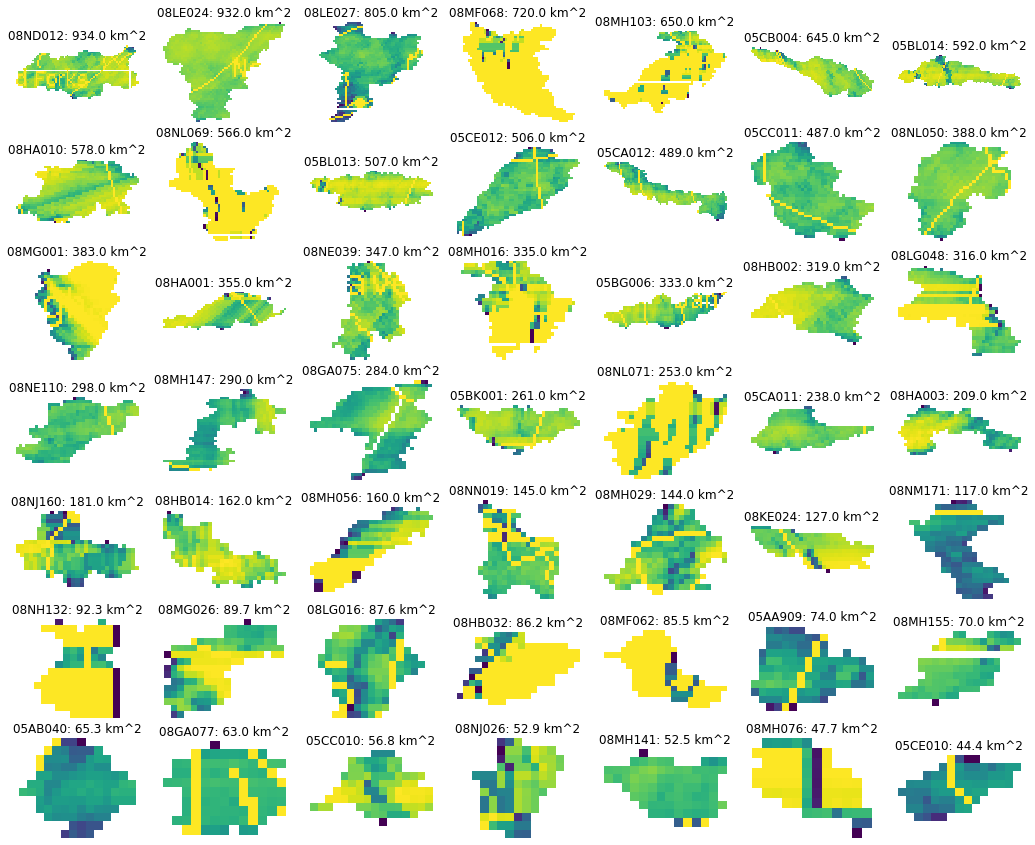

In [70]:
fig, ax = plt.subplots(7, 7, figsize=(18, 15))

colored_maps = []
rows = 7
cols = 7
n = 0
r, c = 0, 0

stations = station_data['Station Number'].values[:49]
    
for n in range(len(stations)):
    stn = stations[n]
    print('{} ({}/{})'.format(stn, n, len(stations)))
    t0 = time.time()
    base_image = get_sample_img(stn)   
    stn_dat = stations_df[stations_df['Station Number'] == stn]
    stn_da = stn_dat['Gross Drainage Area (km2)']
#     ax[r, c].imshow(base_image, alpha=0.5)
    colorized_img_array = construct_precip_histogram(stn)
    remapped_colors_array = reset_bg_colors(base_image, colorized_img_array)
    ax[r, c].imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)
    
    ax[r, c].axis('off')
    ax[r, c].set_title(stn + ': {:.1f} km^2'.format(stn_da.values[0]))
    c += 1
    if c == 7:
        c = 0
        r += 1

    n += 1

# plt.axis('off')

## Reconstruct Hydrograph

In [71]:
grids = []
n = 0
# stations_1 = stations[:5]
for stn in ['08MH147']:
    print(stn)
    print('{} ({}/{})'.format(stn, n, len(stations)))
    grids.append((stn, create_plot_grid(stn)))
    n += 1
    
show(arrange_plots_into_grid(grids[0]))

08MH147
08MH147 (0/49)
Station: 08MH147 (290.0 km^2)
